## Quantum Noising, classical U-Net ##
The U-Net has three variants (all classical on quantum encoded data): straight forward down/upsampling, same with validation, U-Net with self-attention in between layers.

In [ ]:
import numpy as np
import h5py
import torch
from angle_encoding_script import angle_encoding
from haar_noising_script import apply_haar_scrambling

filename = "../../../data/QG1_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 1000

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

importing Jupyter notebook from haar_noising.ipynb
torch.Size([1000, 8, 8, 4])
torch.Size([1000, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_17412\3484829036.py:18: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:300.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, intermediate_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, intermediate_dim)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(intermediate_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
intermediate_dim = 16

model = DiffusionModel(input_dim, hidden_dim, output_dim, intermediate_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


Epoch [1/60], Loss: 1.0113, FID: 241.9215
Epoch [2/60], Loss: 0.9530, FID: 221.6295
Epoch [3/60], Loss: 0.8744, FID: 193.8053
Epoch [4/60], Loss: 0.7692, FID: 161.2691
Epoch [5/60], Loss: 0.6444, FID: 133.4073
Epoch [6/60], Loss: 0.5367, FID: 116.1209
Epoch [7/60], Loss: 0.4754, FID: 96.2609
Epoch [8/60], Loss: 0.3983, FID: 74.0035
Epoch [9/60], Loss: 0.3132, FID: 55.7882
Epoch [10/60], Loss: 0.2407, FID: 44.2151
Epoch [11/60], Loss: 0.1956, FID: 37.1903
Epoch [12/60], Loss: 0.1666, FID: 30.3916
Epoch [13/60], Loss: 0.1393, FID: 24.5667
Epoch [14/60], Loss: 0.1193, FID: 21.4501
Epoch [15/60], Loss: 0.1069, FID: 18.9471
Epoch [16/60], Loss: 0.1001, FID: 17.6723
Epoch [17/60], Loss: 0.0897, FID: 15.0256
Epoch [18/60], Loss: 0.0829, FID: 13.8417
Epoch [19/60], Loss: 0.0744, FID: 14.0351
Epoch [20/60], Loss: 0.0749, FID: 14.5440
Epoch [21/60], Loss: 0.0742, FID: 13.5956
Epoch [22/60], Loss: 0.0709, FID: 12.9659
Epoch [23/60], Loss: 0.0708, FID: 12.1820
Epoch [24/60], Loss: 0.0682, FID: 11.

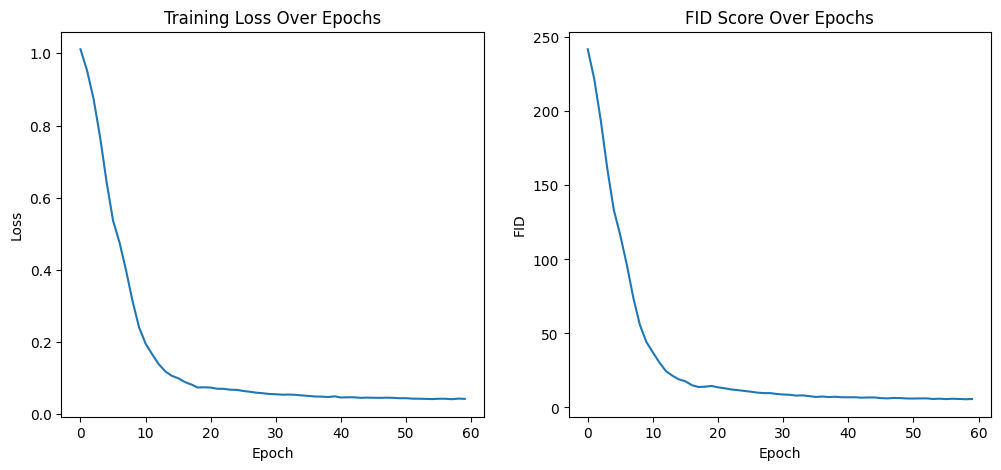

In [10]:
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_decoded_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid


num_epochs = 60
loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    denoised_states = model(scrambled_states.view(num_samples, -1))
    denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
    decoded_data = decode(denoised_states)
    decoded_data = flip(decoded_data)

    mu1, sigma1 = calculate_statistics(data_X)
    mu2, sigma2 = calculate_statistics(decoded_data)
    fid = calculate_fid(mu1, sigma1, mu2, sigma2)
    fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(fid_scores)
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')

plt.show()


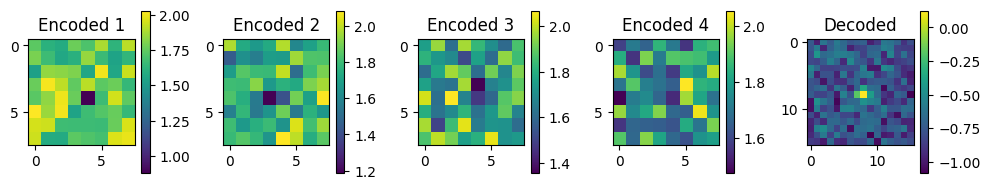

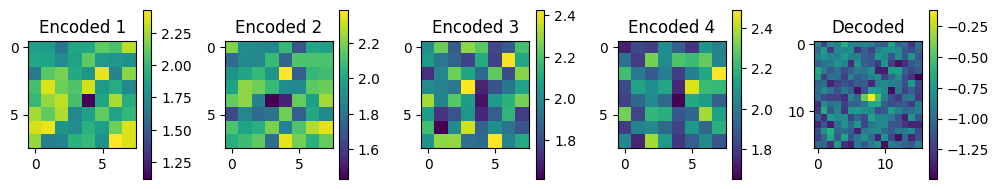

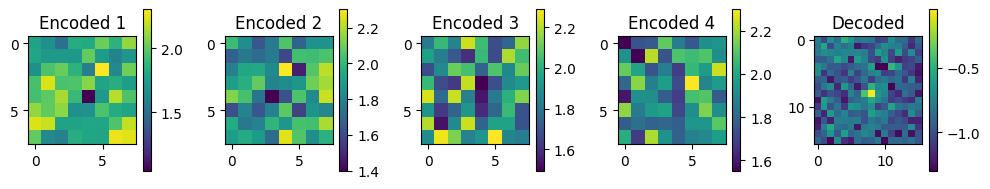

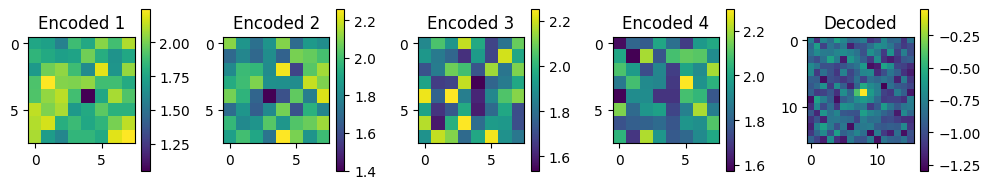

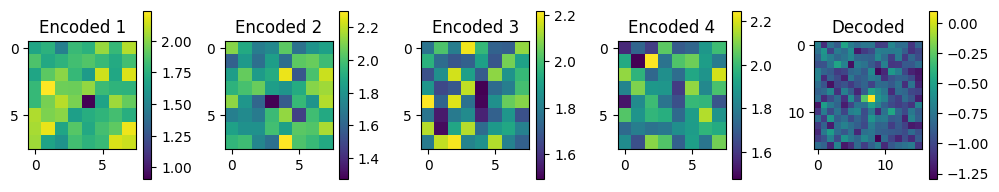

In [12]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)
Epoch [1/50], Loss: 1.0335, Val Loss: 0.9952, FID: 252.9401
Epoch [2/50], Loss: 0.9954, Val Loss: 0.9579, FID: 243.3225
Epoch [3/50], Loss: 0.9568, Val Loss: 0.9017, FID: 228.8024
Epoch [4/50], Loss: 0.8966, Val Loss: 0.8213, FID: 208.0468
Epoch [5/50], Loss: 0.8125, Val Loss: 0.7173, FID: 181.1227
Epoch [6/50], Loss: 0.7030, Val Loss: 0.5973, FID: 149.9978
Epoch [7/50], Loss: 0.5903, Val Loss: 0.4816, FID: 119.8743
Epoch [8/50], Loss: 0.4967, Val Loss: 0.3918, FID: 96.3759
Epoch [9/50], Loss: 0.4442, Val Loss: 0.3176, FID: 77.0636
Epoch [10/50], Loss: 0.3859, Val Loss: 0.2502, FID: 59.7055
Epoch [11/50], Loss: 0.3053, Val Loss: 0.1974, FID: 46.1833
Epoch [12/50], Loss: 0.2342, Val Loss: 0.1642, FID: 

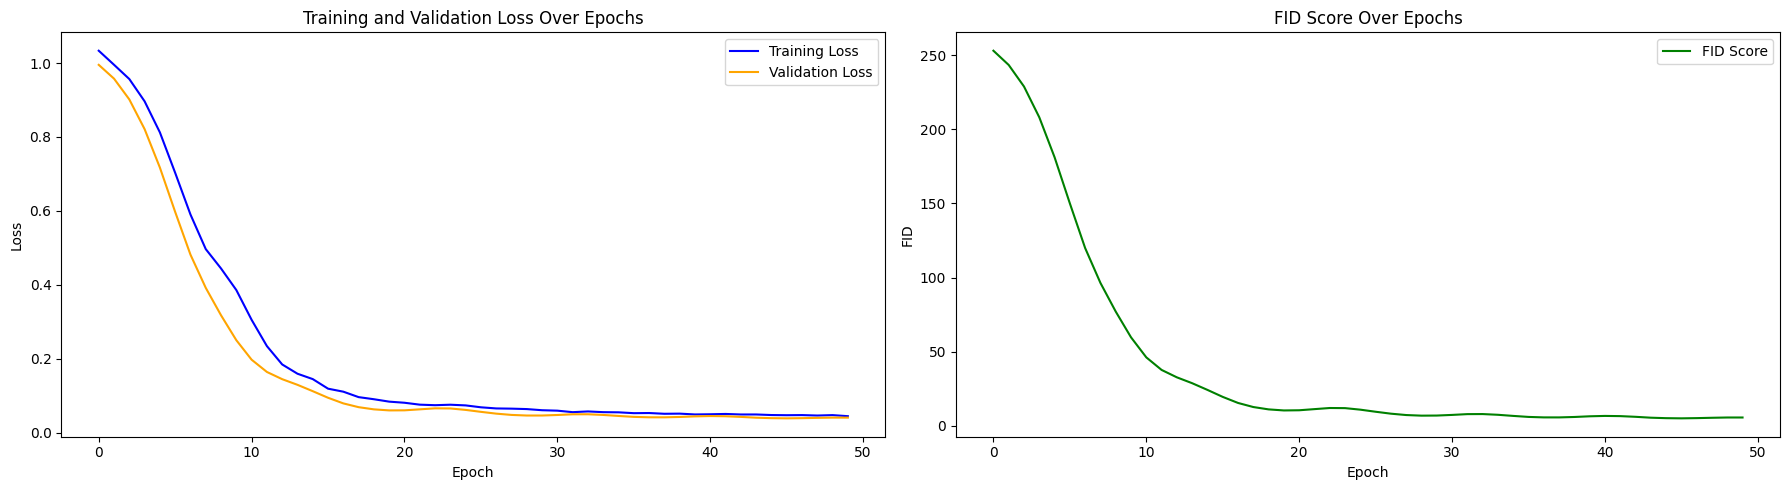

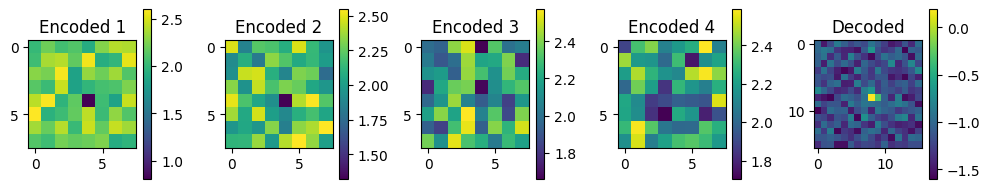

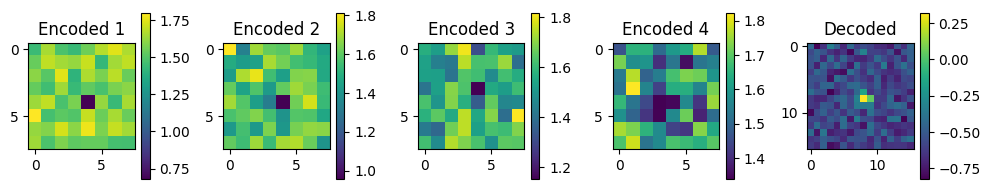

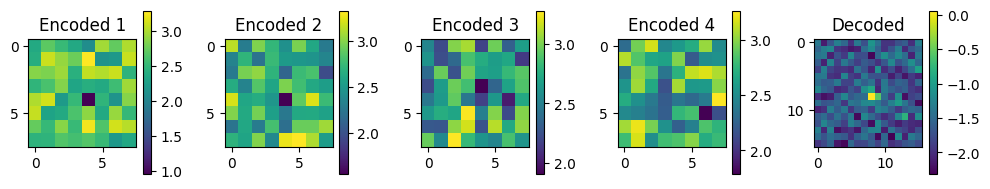

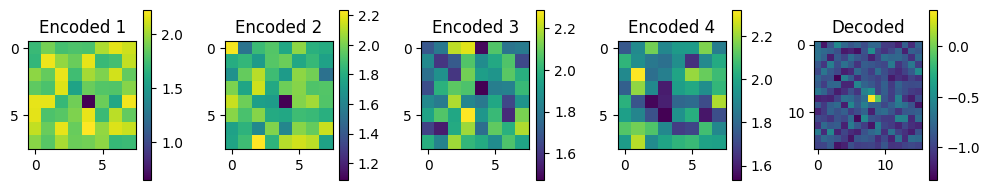

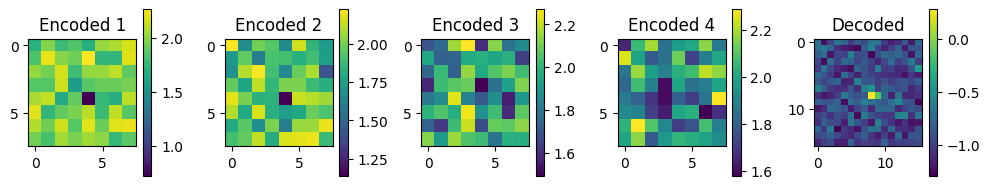

In [13]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, intermediate_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, intermediate_dim)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(intermediate_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
intermediate_dim = 16

model = DiffusionModel(input_dim, hidden_dim, output_dim, intermediate_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_decoded_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)


In [ ]:
from sklearn.model_selection import train_test_split


train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class UNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, intermediate_dim):
        super(UNet, self).__init__()
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.attention1 = SelfAttention(hidden_dim)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.attention2 = SelfAttention(hidden_dim * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, intermediate_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(intermediate_dim, intermediate_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.attention3 = SelfAttention(intermediate_dim)

        self.upconv2 = nn.ConvTranspose2d(intermediate_dim, hidden_dim * 2, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.attention4 = SelfAttention(hidden_dim * 2)

        self.upconv1 = nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.attention5 = SelfAttention(hidden_dim)

        self.output_layer = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        a1 = self.attention1(e1)
        p1 = self.pool1(a1)

        e2 = self.encoder2(p1)
        a2 = self.attention2(e2)
        p2 = self.pool2(a2)

        b = self.bottleneck(p2)
        b = self.attention3(b)

        u2 = self.upconv2(b)
        cat2 = torch.cat([u2, a2], dim=1)
        d2 = self.decoder2(cat2)
        d2 = self.attention4(d2)

        u1 = self.upconv1(d2)
        cat1 = torch.cat([u1, a1], dim=1)
        d1 = self.decoder1(cat1)
        d1 = self.attention5(d1)

        out = self.output_layer(d1)
        return out

input_channels = 4  # 8x8x4 reshaped as 4 channels
output_channels = 4  # 8x8x4 reshaped as 4 channels

model = UNet(input_channels, hidden_dim=64, output_dim=output_channels, intermediate_dim=128)  # Reduced hidden dimensions
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

print(model)


# same as before

num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), 4, 8, 8))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), 4, 8, 8))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), 4, 8, 8))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), 4, 8, 8))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), 4, 8, 8))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')


UNet(
  (encoder1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (attention1): SelfAttention(
    (query_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (attention2): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2

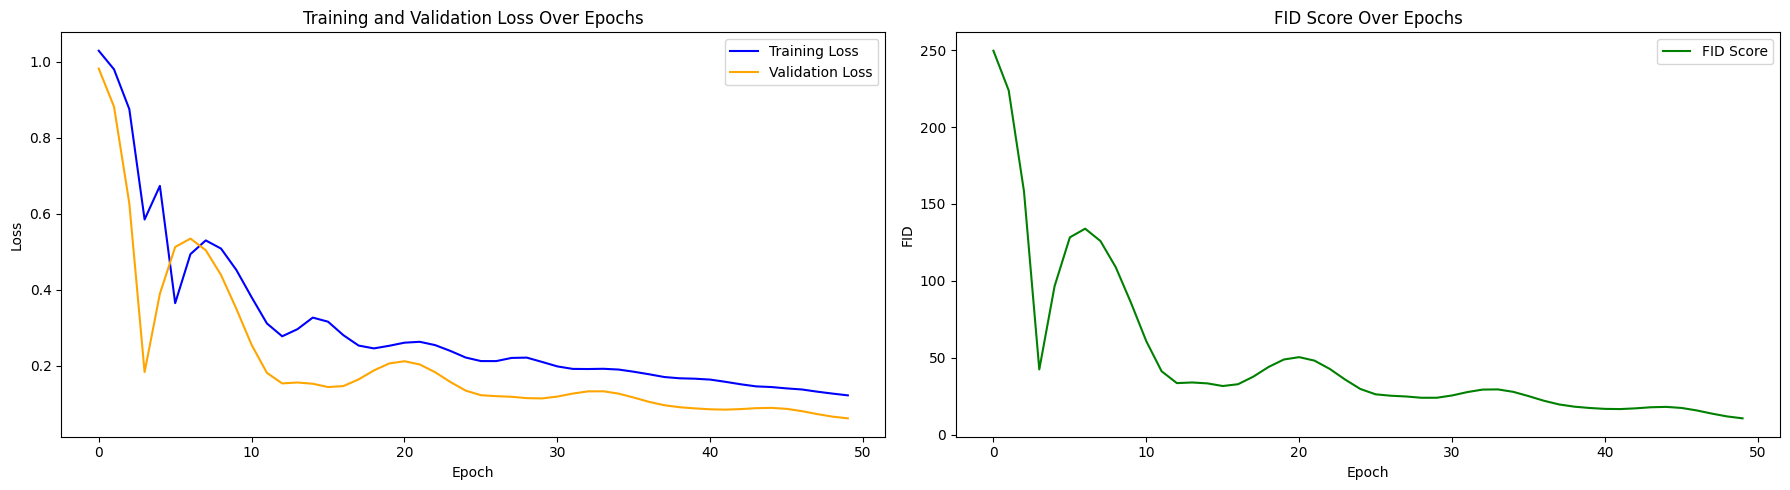

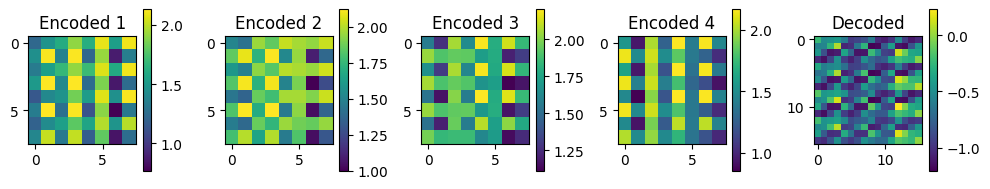

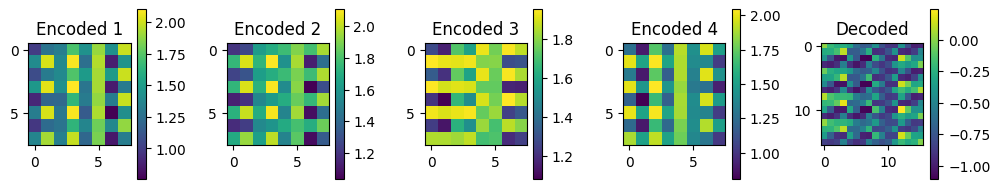

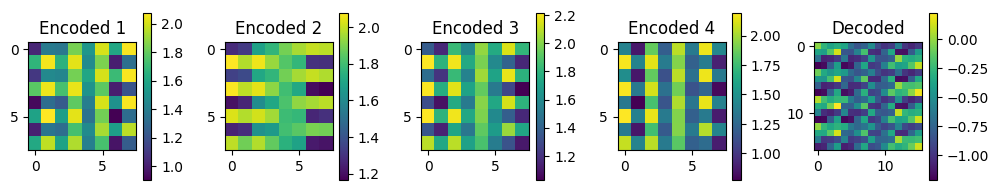

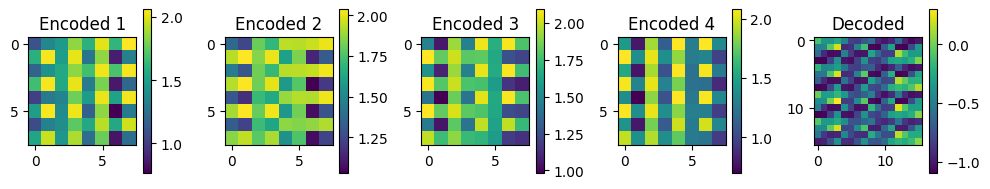

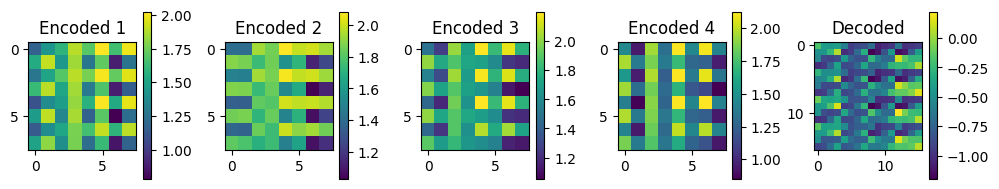

In [30]:

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

def generate_new_images(model, num_images, input_dim=4*8*8):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, 4, 8, 8)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)


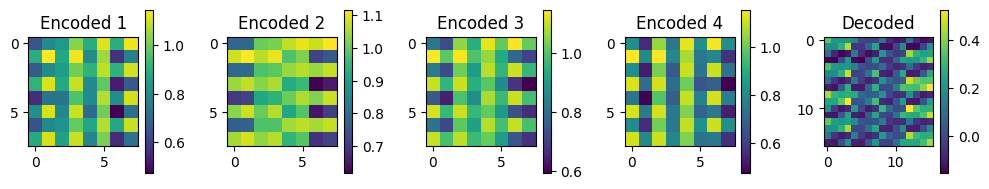

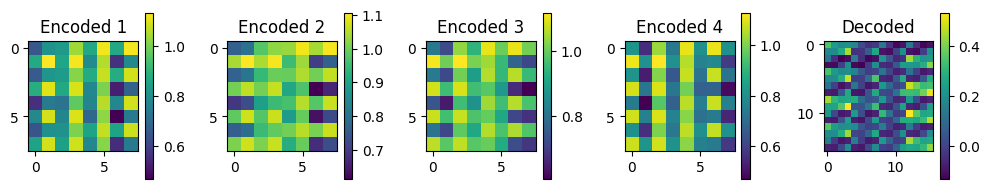

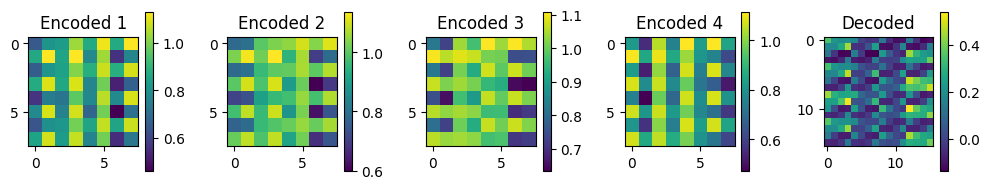

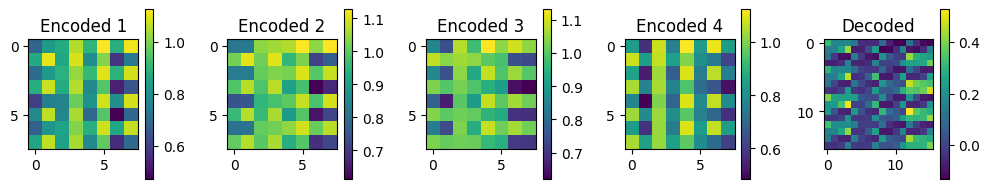

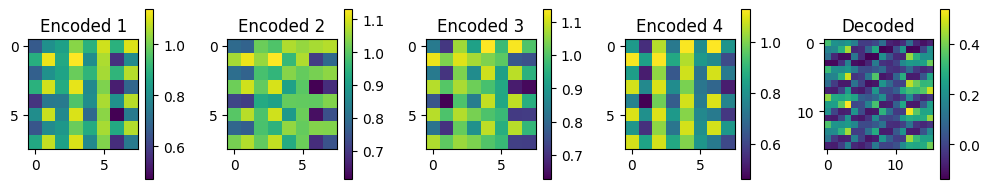

In [ ]:
from scipy.stats import unitary_group

def generate_random_quantum_states(num_samples, seed=None):
    random_quantum_states = []

    for sample in range(num_samples):
        random_state = []
        for i in range(8):
            channels = []
            for j in range(8):
                U = haar_random_unitary(seed)
                random_vector = np.random.rand(4)
                scrambled_state = np.dot(U, random_vector)
                scrambled_state /= np.linalg.norm(scrambled_state)
                channels.append(scrambled_state)

                if seed is not None:
                    seed += 1
            random_state.append(channels)
        random_quantum_states.append(random_state)

    return np.array(random_quantum_states)

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(4)

# Updated generate_new_images function
def generate_new_images(model, num_images, seed=None):
    model.eval()  
    with torch.no_grad():
        
        random_quantum_states = generate_random_quantum_states(num_images, seed)
        random_quantum_states = torch.tensor(random_quantum_states, dtype=torch.float32)
        
        for i in range(num_images):
            random_state = random_quantum_states[i].view(1, 4, 8, 8)
            
            generated_data = model(random_state)
            generated_data = generated_data.view(1, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[0, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[0], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)
